In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.init as init
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
flatten = lambda x: x.view(-1)

batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(flatten)
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class Single(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Single, self).__init__()
        self.layers = nn.ModuleList()

        for _ in range(num_layers):
            self.layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size
            self.layers.append(nn.ReLU())

        self.fc_out = nn.Linear(hidden_size, output_size)

        # List to store norms
        self.norms = []

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            if i % 2 == 0:
                norm = torch.norm(x)
                self.norms.append(norm.item())

        x = self.fc_out(x)
        return x

def single_init_weights(module):
    if isinstance(module, nn.Linear):
        init.orthogonal_(module.weight, gain=init.calculate_gain('relu'))
        init.constant_(module.bias, 0)

input_size = 784  
hidden_size = 256  
output_size = 10  
num_layers = 100  

single_model = Single(input_size, hidden_size, output_size, num_layers)

single_model.apply(single_init_weights)

Single(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features=256, out_features=256, bias=True)
    (19): ReLU()
    (20): Linear(in_features=256, out_features=256, bias=True)
    (21): ReLU()
    (22): Linear(in_features=256, out_features=256, bias=True)
    (23): ReLU()
    (24): Linear(i

In [4]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(single_model.parameters(), lr=0.0001)

single_model = single_model.to(device)

epoch_list = []
loss_list = []

for epoch in range(num_epochs):
    single_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = single_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_list.append(epoch + 1)
    loss_list.append(total_loss / len(train_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    torch.save(single_model.state_dict(), f'/home/dew/THAKRAN/TDL/ckpts/relu/epoch_{epoch+1}.pth')
    
with open("relu_loss", "wb") as fp:   
    pickle.dump(loss_list, fp)

Epoch 1/100, Loss: 1.9306709678696672
Epoch 2/100, Loss: 1.1426709012817473
Epoch 3/100, Loss: 0.8296399579119327
Epoch 4/100, Loss: 0.6682078400209769
Epoch 5/100, Loss: 0.5742254088174051
Epoch 6/100, Loss: 0.5062026502544692
Epoch 7/100, Loss: 0.4565084273579405
Epoch 8/100, Loss: 0.41687629823046707
Epoch 9/100, Loss: 0.3861600306750869
Epoch 10/100, Loss: 0.3589614923717752
Epoch 11/100, Loss: 0.3377082815715499
Epoch 12/100, Loss: 0.3199657281435756
Epoch 13/100, Loss: 0.3019364079964885
Epoch 14/100, Loss: 0.2874655203103447
Epoch 15/100, Loss: 0.27573753850085775
Epoch 16/100, Loss: 0.262428441865326
Epoch 17/100, Loss: 0.2534791420736134
Epoch 18/100, Loss: 0.2431254594116164
Epoch 19/100, Loss: 0.23550871731455264
Epoch 20/100, Loss: 0.22797741621399104
Epoch 21/100, Loss: 0.22019105046185286
Epoch 22/100, Loss: 0.213297374888079
Epoch 23/100, Loss: 0.20596194849697066
Epoch 24/100, Loss: 0.1990806212616977
Epoch 25/100, Loss: 0.19525394797015355
Epoch 26/100, Loss: 0.1918221

In [5]:
# single_model.load_state_dict(torch.load('/home/dew/THAKRAN/TDL/ckpts/relu/epoch_100.pth'))
single_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = single_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 94.03%


In [23]:
class CustomLinear(nn.Module):
    def __init__(self, input_size, output_size, activation):
        super(CustomLinear, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.activation = activation

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class Double(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Double, self).__init__()
        self.layers = nn.ModuleList()
        self.norms = []  
        
        for i in range(num_layers):
            activation = nn.ReLU() if i % 2 == 0 else nn.SELU()
            self.layers.append(CustomLinear(input_size, hidden_size, activation))
            input_size = hidden_size

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.norms = [] 
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            norm = torch.norm(x)
            self.norms.append(norm.item())

        x = self.fc_out(x)
        return x

def double_init_weights(module):
    if isinstance(module, CustomLinear):
        if isinstance(module.activation, nn.ReLU):
            init.orthogonal_(module.linear.weight, gain=init.calculate_gain('relu'))
        elif isinstance(module.activation, nn.SELU):
            init.orthogonal_(module.linear.weight, gain=init.calculate_gain('selu'))
        nn.init.constant_(module.linear.bias, 0)

input_size = 784  
hidden_size = 256  
output_size = 10  
num_layers = 100 

double_model = Double(input_size, hidden_size, output_size, num_layers)

double_model.apply(double_init_weights)

Double(
  (layers): ModuleList(
    (0): CustomLinear(
      (linear): Linear(in_features=784, out_features=256, bias=True)
      (activation): ReLU()
    )
    (1): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): SELU()
    )
    (2): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
    )
    (3): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): SELU()
    )
    (4): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
    )
    (5): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): SELU()
    )
    (6): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
    )
    (7): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
 

In [37]:
class CustomLinear(nn.Module):
    def __init__(self, input_size, output_size, activation):
        super(CustomLinear, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.activation = activation

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class Double2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Double2, self).__init__()
        self.layers = nn.ModuleList()
        self.norms = []  
        
        for i in range(num_layers):
            activation = nn.ReLU() if i % 2 == 0 else nn.Tanh()
            self.layers.append(CustomLinear(input_size, hidden_size, activation))
            input_size = hidden_size

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.norms = [] 
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            norm = torch.norm(x)
            self.norms.append(norm.item())

        x = self.fc_out(x)
        return x

def double2_init_weights(module):
    if isinstance(module, CustomLinear):
        if isinstance(module.activation, nn.ReLU):
            init.orthogonal_(module.linear.weight, gain=init.calculate_gain('relu'))
        elif isinstance(module.activation, nn.Tanh):
            init.orthogonal_(module.linear.weight, gain=init.calculate_gain('tanh'))
        nn.init.constant_(module.linear.bias, 0)

input_size = 784  
hidden_size = 256  
output_size = 10  
num_layers = 100 

double2_model = Double2(input_size, hidden_size, output_size, num_layers)

double2_model.apply(double2_init_weights)

Double2(
  (layers): ModuleList(
    (0): CustomLinear(
      (linear): Linear(in_features=784, out_features=256, bias=True)
      (activation): ReLU()
    )
    (1): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): Tanh()
    )
    (2): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
    )
    (3): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): Tanh()
    )
    (4): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
    )
    (5): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): Tanh()
    )
    (6): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (activation): ReLU()
    )
    (7): CustomLinear(
      (linear): Linear(in_features=256, out_features=256, bias=True)


In [24]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(double_model.parameters(), lr=0.0001)

double_model = double_model.to(device)

epoch_list2 = []
loss_list2 = []

for epoch in range(num_epochs):
    double_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = double_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_list2.append(epoch + 1)
    loss_list2.append(total_loss / len(train_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    torch.save(double_model.state_dict(), f'/home/dew/THAKRAN/TDL/ckpts/relu+selu/epoch_{epoch+1}.pth')
    
with open("relu+selu_loss", "wb") as fp:   
    pickle.dump(loss_list2, fp)

Epoch 1/100, Loss: 2.282508991928751
Epoch 2/100, Loss: 2.2068207937517146
Epoch 3/100, Loss: 2.104289145612005
Epoch 4/100, Loss: 1.9774666199806148
Epoch 5/100, Loss: 1.8265296494020329
Epoch 6/100, Loss: 1.6723744373585878
Epoch 7/100, Loss: 1.5311116494857935
Epoch 8/100, Loss: 1.405888012985685
Epoch 9/100, Loss: 1.291551473044129
Epoch 10/100, Loss: 1.187823536426528
Epoch 11/100, Loss: 1.0919957007172265
Epoch 12/100, Loss: 1.0050055765266865
Epoch 13/100, Loss: 0.9283855154570232
Epoch 14/100, Loss: 0.8560991101681805
Epoch 15/100, Loss: 0.7891268210370403
Epoch 16/100, Loss: 0.7202074285318603
Epoch 17/100, Loss: 0.6586204820604467
Epoch 18/100, Loss: 0.6025102642108636
Epoch 19/100, Loss: 0.5515519733876307
Epoch 20/100, Loss: 0.5049439485329809
Epoch 21/100, Loss: 0.4677311990624552
Epoch 22/100, Loss: 0.43557984882326267
Epoch 23/100, Loss: 0.41054862589914914
Epoch 24/100, Loss: 0.3848672642001211
Epoch 25/100, Loss: 0.3595212278748626
Epoch 26/100, Loss: 0.341056857123049

In [25]:
double_model.load_state_dict(torch.load('/home/dew/THAKRAN/TDL/ckpts/relu+selu/epoch_100.pth'))
double_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = double_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Accuracy on the test set: 95.38%


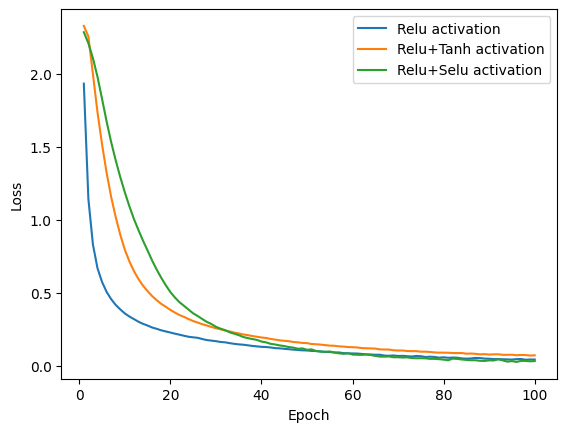

In [30]:
with open('relu_loss', 'rb') as f:
    loss_list = pickle.load(f)
with open('relu+tanh_loss', 'rb') as f:
    loss_list2 = pickle.load(f)
with open('relu+selu_loss', 'rb') as f:
    loss_list3 = pickle.load(f)    
epoch_list=list(range(1, 101))

plt.plot(epoch_list2, loss_list, label='Relu activation')
plt.plot(epoch_list2, loss_list2, label='Relu+Tanh activation')
plt.plot(epoch_list2, loss_list3, label='Relu+Selu activation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/home/dew/THAKRAN/TDL/figs/loss.png')
plt.show()

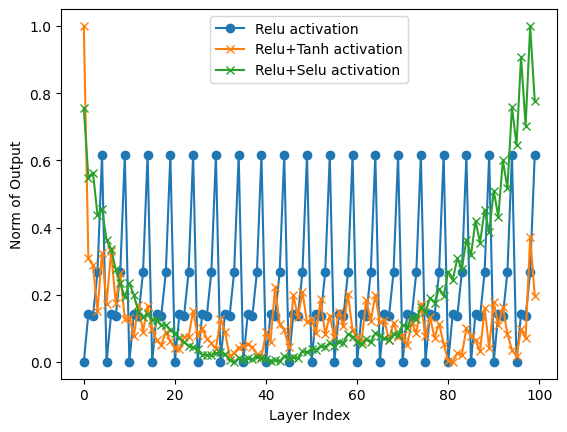

In [36]:
test_input = next(iter(test_loader))[0][0]

single_model.to(device)
single_model.load_state_dict(torch.load('/home/dew/THAKRAN/TDL/ckpts/relu/epoch_100.pth'))
single_model.eval()
output1 = single_model(test_input.to(device))
norms_list1 = single_model.norms
num_layers1 = len(single_model.layers)
norms_array1 = torch.tensor(norms_list1).reshape(100, -1).numpy()

double2_model.to(device)
double2_model.load_state_dict(torch.load('/home/dew/THAKRAN/TDL/ckpts/relu+tanh/epoch_100.pth'))
double2_model.eval()
output2 = double2_model(test_input.to(device))
norms_list2 = double2_model.norms
num_layers2 = len(double2_model.layers)
norms_array2 = torch.tensor(norms_list2).reshape(num_layers2, -1).numpy()

double_model.to(device)
double_model.load_state_dict(torch.load('/home/dew/THAKRAN/TDL/ckpts/relu+selu/epoch_100.pth'))
double_model.eval()
output3 = double_model(test_input.to(device))
norms_list3 = double_model.norms
num_layers3 = len(double_model.layers)
norms_array3 = torch.tensor(norms_list3).reshape(num_layers3, -1).numpy()

def min_max_normalize(arr):
    min_val = arr.min()
    max_val = arr.max()
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr

normalized_norms_array1 = min_max_normalize(norms_array1)
normalized_norms_array2 = min_max_normalize(norms_array2)
normalized_norms_array3 = min_max_normalize(norms_array3)

plt.plot(normalized_norms_array1[:, 0], marker='o', label='Relu activation')
plt.plot(normalized_norms_array2[:, 0], marker='x', label='Relu+Tanh activation')
plt.plot(normalized_norms_array3[:, 0], marker='x', label='Relu+Selu activation')
plt.xlabel('Layer Index')
plt.ylabel('Norm of Output')
plt.legend()
plt.savefig('/home/dew/THAKRAN/TDL/figs/norm.png')
plt.show()

In [ ]:
input_size = 784  
hidden_size = 256  
output_size = 10  
num_layers = 100

num_epochs = 50
learning_rate = 0.0001
num_layers_list = list(range(1, num_layers + 1))

test_accuracy_list2 = []

for num_layer in num_layers_list:

    double_model = Double(input_size, hidden_size, output_size, num_layer)
    double_model.apply(double_init_weights)
    double_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(double_model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        double_model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = double_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    double_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = double_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracy_list2.append(accuracy*100)
    print(f"Number of layers: {num_layer}, Test Accuracy: {accuracy * 100:.2f}%")
    
with open("relu+selu_loss_acc", "wb") as fp:   
    pickle.dump(test_accuracy_list2, fp)
    


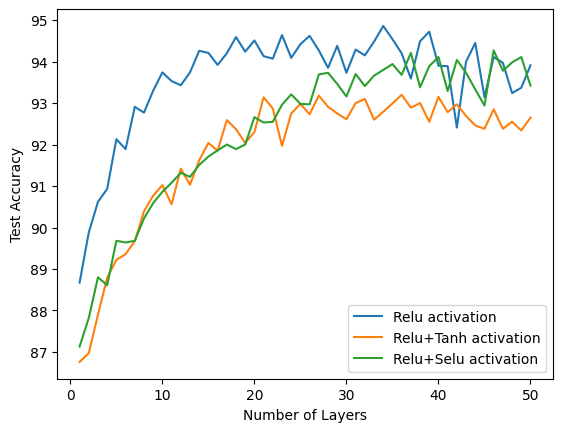

In [2]:
with open('relu_layer_acc', 'rb') as f:
    l1 = pickle.load(f)
with open('relu+tanh_layer_acc', 'rb') as f:
    l2 = pickle.load(f)
with open('relu+selu_layer_acc', 'rb') as f:
    l3 = pickle.load(f)    
num_layers_list=list(range(1, 51))

plt.plot(num_layers_list, l1, label='Relu activation')
plt.plot(num_layers_list, l2,label='Relu+Tanh activation')
plt.plot(num_layers_list, l3,label='Relu+Selu activation')
plt.xlabel('Number of Layers')
plt.ylabel('Test Accuracy')
plt.legend()
plt.savefig('/home/dew/THAKRAN/TDL/figs/layer_vs_acc.png')
plt.show()